### !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

## 1.2 Important Dependencies

In [1]:
#import standard dependecies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - functional APIs
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
# Avoid DOM errors by setting GPU Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth_(gpu, True)

## 1.4 Create Folder Structures

In [4]:
# Setup Paths 
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directeries
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2 Collect Positives and Anchors

## 2.1 Untar Labelled Faces In the wild Dataset

In [6]:
# http://vis-www.cs.umass.edu/lfw/ 

In [7]:
# Uncompress Tar GZ labelled faces in the wild datase
!tar -xf lfw.tgz

In [8]:
# Move lfw Images to the following repo data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [9]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        print(os.path.join('lfw', directory, file))
        print(os.path.join(NEG_PATH, file))

## 2.2 Collect Positive and Anchor classes

In [ ]:
## #importing opencv library
### from cv2 import *

## #code to collect image in different way
### cam_port = 0
### cam = cv2.VideoCapture(cam_port)

## # reading the input using webcam
### result, image = cam.read()

## # If image will detected without any error,
## ## show result
### if result:
    
##     # showing result, it take frame name and image
##     # output
###     cv2.imshow("test", image)
    
##     # saving image in local storage
###     cv2.imwrite(os.path.join(POS_PATH,"test.png"), image)
    
##     # if keyboard interrupt occurs, destroy image
##     # window
###     cv2.waitKey(0)
###     cv2.destroyWindow("test")
    
## ## if captured image is corrupted, moving to else part
### else:
###     print("No image detected. Please! try again")

In [5]:
# import uuid library to generrate unique image names
import uuid

In [6]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while (cap.isOpened()):
    ret, frame = cap.read()
    
#     # cut down frame to 250X250px
#     frame = frame[120:120+250, 200:200+250, :]
    
    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # storing frame in local storage
#     cv2.imwrite(os.path.join(POS_PATH,"test.png"), frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

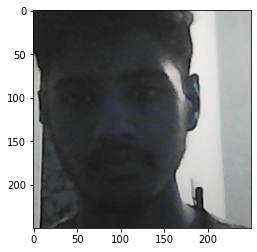

In [7]:
plt.imshow(frame[120:120+250, 200:200+250, :])

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*jpg').take(300)

In [9]:
dir_test = anchor.as_numpy_iterator()

In [10]:
print(dir_test.next())

b'data\\anchor\\0fb9d63e-d758-11ec-92d3-b0a460509de4.jpg'


## 3.2 Preprocessing - Scale and Resize

In [11]:
def preprocess(file_path):
    
    #Read in image from file path
    byte_img = tf.io.read_file(file_path)
    
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # preprocessing steps - resizing the image to be 100X100X3
    img = tf.image.resize(img, (100,100))
    
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    # Returning the image
    return img

In [12]:
img = preprocess('data\\anchor\\0fb9d63e-d758-11ec-92d3-b0a460509de4.jpg')

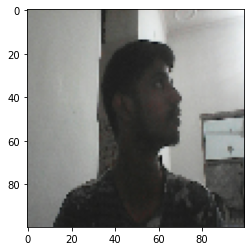

In [13]:
plt.imshow(img)

In [ ]:
dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [15]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()

In [18]:
examples = samples.next()

## 3.4 Build Train and Test partition

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*examples)

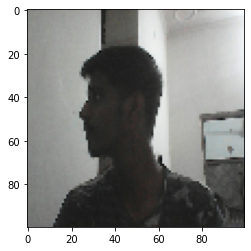

In [21]:
plt.imshow(res[0])

In [22]:
res[2]

1.0

In [23]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [24]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [25]:
train_samples = train_data.as_numpy_iterator()

In [26]:
train_sample = train_samples.next()

In [27]:
len(train_sample[0])

16

In [28]:
# Testing parition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [29]:
inp = Input(shape=(100,100,3), name='input_image')

In [30]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final Embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [31]:
embedding = make_embedding()

In [32]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [33]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
    #Here is jaaduuuu.. - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [34]:
l1 = L1Dist()

## 4.3 Make Siamese Layer

In [35]:
def make_siamese_model():

    # Anchor image inputs in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [36]:
siamese_model = make_siamese_model()

In [37]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [38]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [39]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [40]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [45]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        x = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        ypred = siamese_model(x, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, ypred)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to Siamese Model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

## 5.4 Build Training Loop

In [42]:
def train(data, EPOCHS):
    # loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(train_data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the Model

In [43]:
EPOCHS = 50

In [46]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
2/2 [==============================] - 37s 11s/step

 Epoch 2/50
2/2 [==============================] - 34s 11s/step

 Epoch 3/50
2/2 [==============================] - 39s 13s/step

 Epoch 4/50
2/2 [==============================] - 34s 11s/step

 Epoch 5/50
2/2 [==============================] - 38s 13s/step

 Epoch 6/50
2/2 [==============================] - 34s 11s/step

 Epoch 7/50
2/2 [==============================] - 35s 11s/step

 Epoch 8/50
2/2 [==============================] - 40s 13s/step

 Epoch 9/50
2/2 [==============================] - 41s 13s/step

 Epoch 10/50
2/2 [==============================] - 41s 13s/step

 Epoch 11/50
2/2 [==============================] - 41s 13s/step

 Epoch 12/50
2/2 [==============================] - 42s 13s/step

 Epoch 13/50
2/2 [==============================] - 42s 13s/st

# 6 Evaluate Model